# Setup

## Bibliothèques Python

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from osgeo import gdal
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# libsigma
sys.path.insert(0, os.path.abspath(".."))

from libsigma.read_and_write import (get_origin_coordinates,
                                    load_img_as_array,
                                    write_image,
                                    get_image_dimension
                                    )
from libsigma.classification import get_samples_from_roi
from libsigma.plots import plot_cm

# my_function.py
from my_function import rasterise_gdal, calcul_nari, plot_contrib

## Chemins

# 4.2. Analyse des échantillons


## 4.2.1. Nombre d’échantillons

### Nombre de polygones par classe

#### Diagramme en bâtons

Fichier créé : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


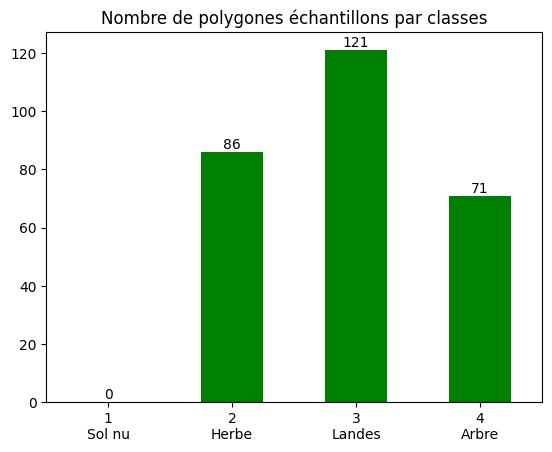

In [2]:
shp_path = os.path.join(
    "..",
    "data",
    "projet_eval",
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence car la liste des classes est connue d'avance 
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
    .fillna(0)
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Affiche les valeurs
for i, val in enumerate(counts):
    ax.text(i, val, int(val), ha="center", va="bottom") 

# Labels de l'axe X depuis le dictionnaire
ax.set_xticklabels([f"{s}\n{labels_strates[s]}" for s in counts.index], rotation=0)

# Titres graphique et axes
ax.set_title("Nombre de polygones échantillons par classes")
plt.xlabel('')
plt.ylabel('')

# Sortie
results_dir = os.path.join("..","results", "figure")

os.makedirs(results_dir,exist_ok=True) # Crée le dossier s'il n'existe pas

results_path = os.path.join(results_dir, "diag_baton_nb_poly_by_class.png")

plt.savefig(results_path)

print("Fichier créé :", os.path.abspath(results_path))

plt.show()

#### Commentaire

On remarque que la distribution des échantillons est **déséquilibrée** : les landes sont la classe majoritaire tandis que **la classe « sol nu » est totalement absente**.

Cela pourra poser des problèmes plus tard, notamment lors de la classification supervisée, en créant des **biais**. En effet, sans échantillon de référence dans cette classe, l'apprentissage sera impossible pour cette classe. Les résultats seront donc à interpréter avec prudence, particulièrement pour la classe « sol nu ».

### Nombre de pixels par classe

#### Contrôles

Tout d'abord, on vérifie que tous nos fichiers de travail sont bien « **alignés** » : même résolution, même CRS, mêmes coordonnées à l'origine, mêmes dimensions. On utilise pour cela principalement des fonctions de ``libsigma``.

##### Résolution spatiale

In [3]:
sys.path.append(os.path.abspath(".."))

from libsigma.read_and_write import get_pixel_size, open_image

data_dir = os.path.join("..","data", "projet_eval")

# liste des rasters
files = sorted(
    f for f in os.listdir(data_dir)
    if f.startswith("bretagne_24-25")
)

pixel_sizes = [
    get_pixel_size(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(pixel_sizes)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même résolution. Taille des pixels :", pixel_sizes[0])
else:
    print("❌ Les images n'ont PAS toutes la même résolution !")
    for f, ps in zip(files, pixel_sizes):
        print(f, ":", ps)

✅ Toutes les images ont la même résolution. Taille des pixels : (10.0, -10.0)


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


##### Système de projection

In [4]:
crs_list = [
    open_image(os.path.join(data_dir, f)).GetProjection()
    for f in files
]

if len(set(crs_list)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont le même CRS :", crs_list[0])
else:
    print("❌ Les images n'ont PAS toutes le même CRS")
    for f, crs in zip(files, crs_list):
        print(f, ":", crs)

✅ Toutes les images ont le même CRS : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


In [5]:
gdf = gpd.read_file(shp_path)

print("CRS du shapefile :", gdf.crs)

CRS du shapefile : EPSG:32630


Toutes les images ainsi que le shapefile sont projetés en WGS 84.

##### Coordonnées du pixel à l'origine

In [6]:
origins = [
    get_origin_coordinates(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(origins)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même origine :", origins[0])
else:
    print("❌ Les images n'ont PAS la même origine")
    for f, origin in zip(files, origins):
        print(f, ":", origin)


✅ Toutes les images ont la même origine : (432950.0, 5368890.0)


##### Dimensions

In [7]:
dimensions = [
    get_image_dimension(
        open_image(os.path.join(data_dir, f))
    )   # on ne garde que (nb_lignes, nb_colonnes)
    for f in files
]

if len(set(dimensions)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même dimension :", dimensions[0])
else:
    print("❌ Les images n'ont PAS toutes la même dimension")
    for f, dim in zip(files, dimensions):
        print(f, ":", dim)

✅ Toutes les images ont la même dimension : (612, 1533, 6)


La fonction `get_image_dimension()` renvoie un triplet *(lignes, colonnes, bandes)*.

Les dimensions spatiales (lignes et colonnes) sont identiques pour toutes les images, ce qui confirme leur bon alignement.

En revanche, la présence de **6 bandes** par fichier est suspecte étant donné que **les images Sentinel-2 comportent 13 bandes** (dont on en sélectionne parfois 10).

On comprend donc que ces 6 bandes correspondent aux **6 dates d’acquisition**, et non à des bandes spectrales. Les différentes bandes spectrales sont donc réparties entre plusieurs fichiers (ce qui est cohérent avec leur nom « ``BXX`` »), chacun empilant les informations temporelles.

En l'état, le jeu de données fourni n'est **pas exploitable** car l’organisation des images est différente : **chaque fichier correspond à une bande spectrale** donnée, dans laquelle est « empilée » la **dimension temporelle**.

Afin de pouvoir travailler sur ces fichiers, il est donc nécessaire de **réorganiser ces données**.

#### Réorganisation des données

On fait l'**hypothèse** que l'ordre des bandes suit l'ordre chronologique des dates fournies dans l'énoncé, donc :

- 2025-03-31 → Bande 1
- 2025-04-10 → Bande 2
- 2025-05-15 → Bande 3
- 2025-06-17 → Bande 4
- 2025-07-12 → Bande 5
- 2025-08-10 → Bande 6

In [8]:
dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]

# Charge les 10 fichiers
arrays_by_band = [
    load_img_as_array(os.path.join(data_dir, f"bretagne_24-25_{b}.tif"))
    for b in bands
]

img_ds = open_image(os.path.join(data_dir, f"bretagne_24-25_{bands[0]}.tif"))

for t, date in enumerate(dates):
    img_t = np.stack([arr[:, :, t] for arr in arrays_by_band], axis=2)

    output_dir = os.path.join("..",data_dir, "data_ready")
    os.makedirs(output_dir,exist_ok=True) # Crée le dossier s'il n'existe pas
    output_path = os.path.join(output_dir, f"bretagne_24-25_{date}.tif")


    write_image(
        out_filename=output_path,
        array=img_t,
        data_set=img_ds
    )

print("Fichier créé :", os.path.abspath(output_path))

Fichier créé : /home/onyxia/data/projet_eval/data_ready/bretagne_24-25_2025-08-10.tif


Ce code crée un nouveau dossier ``data/projet_eval/data_ready`` qui contient les images retravaillées : 10 bandes pour chacune des 6 dates.

On vérifie que la manipulation s'est bien déroulée :

In [9]:
for date in dates:
    fname = f"bretagne_24-25_{date}.tif"
    fpath = os.path.join(output_dir, fname)

    dims = get_image_dimension(open_image(fpath))
    print(f"{fname} → {dims}")

bretagne_24-25_2025-03-31.tif → (612, 1533, 10)
bretagne_24-25_2025-04-10.tif → (612, 1533, 10)
bretagne_24-25_2025-05-15.tif → (612, 1533, 10)
bretagne_24-25_2025-06-17.tif → (612, 1533, 10)
bretagne_24-25_2025-07-12.tif → (612, 1533, 10)
bretagne_24-25_2025-08-10.tif → (612, 1533, 10)


#### Diagramme en bâtons

Pour **compter les pixels**, on peut choisir une image au hasard puisqu'on a vérifié qu'elles étaient toutes « alignées ».

Pour **rasteriser** le shapefile, OTB n'est pas disponible dans cet environnement, on utilise donc **GDAL**.

In [10]:
image_ref = os.path.join("..", "data", "projet_eval", "data_ready", "bretagne_24-25_2025-03-31.tif")
echantillon_rasterize = os.path.join("..", "temp", "echantillon_rasterize.tif")

rasterise_gdal(
    shp_path=shp_path,
    ref_image=image_ref,
    out_raster=echantillon_rasterize,
    attribute="strate",
    gdal_dtype=gdal.GDT_Float32
)

print("Fichier créé :", os.path.abspath(echantillon_rasterize))

Fichier créé : /home/onyxia/work/temp/echantillon_rasterize.tif


La rasterisation a été réalisée selon la règle par défaut de GDAL, où un pixel est affecté à une classe si son centre est inclus dans le polygone. L’option ``ALL_TOUCHED`` n’a pas été utilisée afin d’éviter une surestimation des surfaces.

C'est la raison pour laquelle on peut observer des « débordements » des polygones par rapport aux pixels (voir ci-dessous).

<center>
    <figure>
    <img src="img/rasterisation.png" width="200">
    <figcaption>Le polygone « déborde » à certains endroits<br/>car les centres des pixels associés ne tombent pas dans le polygone.</figcaption>
    </figure>
</center>

Fichier créé : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png


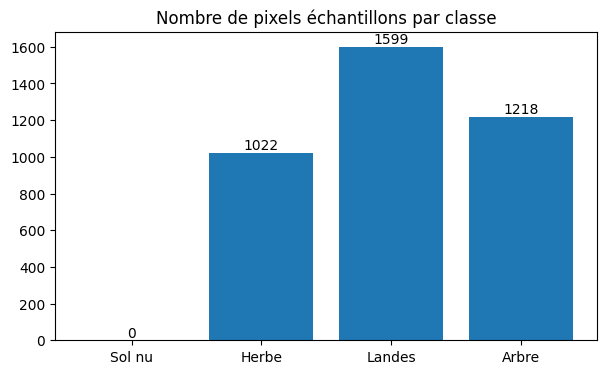

In [11]:
_, Y, _ = get_samples_from_roi(image_ref, echantillon_rasterize)

values, counts = np.unique(Y, return_counts=True)

counts_dict = dict(zip(values.flatten().tolist(), counts.tolist()))
ordered_classes = list(labels_strates.keys())
ordered_counts = [counts_dict.get(c, 0) for c in ordered_classes]
ordered_labels = [labels_strates[c] for c in ordered_classes]

plt.figure(figsize=(7, 4))
plt.bar(ordered_labels, ordered_counts)
for i, v in enumerate(ordered_counts):
    plt.text(i, v, str(int(v)), ha="center", va="bottom")

plt.title("Nombre de pixels échantillons par classe")

results_path = os.path.join(results_dir, "diag_baton_nb_pix_by_class.png")
plt.savefig(results_path, dpi=300, bbox_inches="tight")

print("Fichier créé :", os.path.abspath(results_path))

plt.show()


#### Commentaire

Ce diagramme met en évidence que **la classe « landes » occupe la surface la plus importante** (plus grand nombre de pixels).

Comme les pixels sont de taille 10 × 10 mètres, nous avons les surfaces suivantes :

- 10.22 hectares classés en « herbe »
- 15.99 hectares classés en « landes »
- 12.18 hectares classés en « arbre »

En cohérence avec le diagramme précédent, nous n'avons **aucun pixel** pour dans la classe « sol nu »

Toutes les images étant désormais parfaitement alignées sur la même grille, nous pouvons maintenant travailler dessus pour produire des cartes.

## 4.2.2. Phénologie des strates, mise en évidence des landes

### Série temporelle

In [12]:
nodata = -9999.0

data_ready_dir = os.path.join("..", "data", "projet_eval", "data_ready")
files_ready = sorted(
    f for f in os.listdir(data_ready_dir)
)

# Calcul du NARI pour chaque date
nari_list = []
for f in files_ready:
    img_path = os.path.join(data_ready_dir, f)
    img = load_img_as_array(img_path)

    # B03 index 1, B05 index 3 (ordre validé chez toi)
    nari = calcul_nari(img, nodata=nodata)
    nari_list.append(nari)

# Empile les dates pour former une série temporelle
nari_stack = np.stack(nari_list, axis=2).astype("float32")

# Référence : une image data_ready (garantit l'alignement de la sortie avec les entrées)
ref_ds = open_image(os.path.join(data_ready_dir, files_ready[0]))
results_dir = os.path.join("..", "results")
out_path = os.path.join(results_dir, "ARI_serie_temp.tif")

write_image(
    out_filename=out_path,
    array=nari_stack,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Float32
)

# Définit la valeur de NoData car la fonction write_image ne le permet pas
ds_out = gdal.Open(out_path, gdal.GA_Update)
for i in range(1, ds_out.RasterCount + 1):
    ds_out.GetRasterBand(i).SetNoDataValue(nodata)
ds_out = None
ref_ds = None

print("Fichier créé :", os.path.abspath(out_path))

Fichier créé : /home/onyxia/work/results/ARI_serie_temp.tif


### Moyenne & écart-type

Fichier créé : /home/onyxia/work/results/figure/ARI_series.png


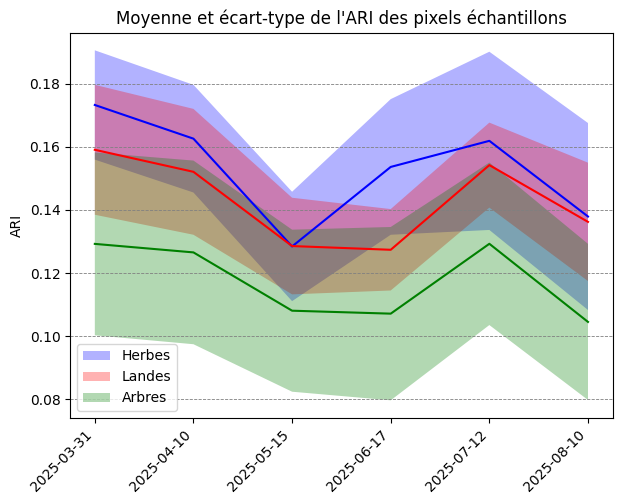

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

ari_path = os.path.join(results_dir, "ARI_serie_temp.tif")
echantillon_rasterize = os.path.join("..", "temp", "echantillon_rasterize.tif")


dict_ARI, Y, t = get_samples_from_roi(
    raster_name=ari_path,
    roi_name=echantillon_rasterize,
    output_fmt="by_label"
)

colors = ['blue', 'red', 'green']
labels = ['Herbes', 'Landes', 'Arbres']

for X, color, label in zip(dict_ARI.values(), colors, labels):
    # X : (n_pixels, 6 dates)
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    ax.plot(means, color=color)
    ax.fill_between(
        range(len(means)),
        means - stds,
        means + stds,
        facecolor=color,
        alpha=0.3,
        label=label
    )

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45, ha="right")
ax.set_ylabel("ARI")
ax.set_title("Moyenne et écart-type de l'ARI des pixels échantillons")
ax.legend()
ax.yaxis.grid(True, linestyle="--", linewidth=0.6,color='gray')

out_path = os.path.join(results_dir, "figure", "ARI_series.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

print("Fichier créé :", os.path.abspath(out_path))

plt.show()

#### Commentaire

<u>Rappel de l'objectif</u> : « *étudier si la classe de landes se distingue des autres grâce au ARI et comment* ».

Dans la période donnée, entre mars et août, l'ARI des landes varie **entre 0.12 et 0.16**, avec une diminution notable au cours des mois de mai-juin pour remonter au début de l'été.

Les strates **herbes et landes** présentent des **valeurs d'ARI relativement proches** et leurs intervalles de variabilité (écart-types) se recouvrent partiellement, voire totalement en été.

À un instant $t$, l'ARI est donc un **bon indicateur pour distinguer les landes des arbres**, mais il n'est **pas suffisant pour les distinguer des herbes**.

En revanche, une **analyse temporelle** sur la période donnée permet de bien caractériser les landes : leur ARI est systématiquement **supérieur à celui des arbres** et la **chute** au mois de mai est **moins prononcée** que pour les herbes.

# 4.3. Production d'une carte de strates à l'échelle du pixel

## Préparation des données

La première étape consiste à **construire le jeu de données d’apprentissage**, composé d’une matrice de variables explicatives $X$ et d’un vecteur de labels $y$ correspondant aux strates issues des polygones d’échantillonnage.

Pour les **données en entrées** $X$, il y a plusieurs possibilités. On peut entraîner le modèle sur :
1. L'ensemble des 10 bandes
2. L'ensemble des 10 bandes + la bande NARI que nous avons créée précédemment
3. Seulement les bandes qui interviennent dans le calcul du NARI (``B03`` et ``B05``)

Nous allons ici préférer la **première option** :

- En effet, la bande du **NARI est une combinaison de bandes** déjà existantes et le modèle pourra reconnaître le « ***pattern*** » qui a permis de construire cet indice (à condition de ne pas choisir un modèle linéaire, donc cohérent avec l'utilisation de RF). Le NARI n'est donc pas en soi une donnée explicative et nous allons donc l'exclure pour **limiter le bruit** lors de l'apprentissage.

- De plus, l'utilisation de seulement deux bandes semble assez **limité** pour le but de ce projet (« *produire une carte des strates* »). Les bandes 3 (vert) et 5 (*red edge*) ont permis de calculer un indicateur concernant la présence d'anthocyanes, mais limiter l'apprentissage à ces bandes reviendrait à dire que la classification des strates **ne dépend que de celles-ci**. Or, on peut imaginer que d'**autres facteurs**, que le modèle va tenter de détecter, interviennent dans la différenciation des strates. Nous verrons par la suite la **contribution des variables**, c'est-à-dire à quel point chaque bande explique la classification dans telle ou telle strate.

In [14]:
# Construction des données d'apprentissage

# Principe : on parcourt les dates, on extrait les bandes pour chaque date,
# puis on les « empile » (np.hstack).

X_list = []

# On va boucler sur les 6 dates
for date_image in files_ready:
    image_by_date = os.path.join(data_ready_dir, date_image) # Chemin vers image à UNE date

    # X_date : (n_pixels, 10) = valeurs des 10 bandes pour les pixels échantillons à cette date
    # Y      : (n_pixels, 1)  = strate (labels) des mêmes pixels (issu du raster ROI)
    X_date, Y, _ = get_samples_from_roi(
        raster_name=image_by_date,
        roi_name=echantillon_rasterize,
    )

    X_list.append(X_date)

# Concaténation des 6 dates
X = np.hstack(X_list)

# Mise en forme des labels pour scikit learn
y = Y[:, 0]

Ci-dessus, nous sommes passés d’une structure composée de **plusieurs matrices correspondant chacune à une date d’acquisition** à une matrice unique dans laquelle **chaque pixel est décrit par l’ensemble de ses variables spectrales** sur toutes les dates.

Cela a été nécessaire pour entraîner le modèle en **intégrant la dimension temporelle** et non en l'entraînant à une date arbitraire (cela aurait des résultats significativement différents selon la saison).

En résumé, **on concatène l'ensemble des valeurs spectrales à chaque date** dans un seul et même élément de la liste plutôt que de fournir au classifieur une succession de matrices indépendantes (bien que nous sachions qu'elles sont classées par date, le classifieur n'a aucune notion du temps), ce qui reviendrait à entraîner le modèle sur des observations à l'instant $t$ sans réelle prise en compte de la dynamique temporelle.

## 4.3.1. Choix du classifieur et sa paramétrisation

Le classifieur imposé est **RandomForest** et nous devons **optimiser les hyperparamètres** selon le tableau suivant :

|    Hyperparamètre    |    Valeurs     |
|--------------------: | :----------------------|
| ``n_estimators``     | ``50``, ``100``, ``150``, ``200``, ``300`` |
| ``max_depth``        | ``None``, ``10``, ``15``, ``20``|
| ``max_features``     | ``None``, ``sqrt``, ``log2``|
| ``min_samples_leaf`` | ``1``, ``5``|

## 4.3.2. Stratégie de validation

Afin de sélectionner la configuration parmi les 120 possibles qui donne les meilleures performances, ces hyperparamètres doivent être testés à l'aide d'une recherche sur grille (**GridSearchCV**) combinée à une validation croisée.

Pour accélérer le temps de calcul, on parallélise les traitements (``n_jobs=-1``).

On choisit la stratégie ***StratifiedGroupKFold*** car on a ici un certain **déséquilibre** entre le nombre de pixels d'entraînement selon les classes et il est nécessaire de conserver des **proportions** comparables. On voudrait également **grouper les pixels** selon le polygone auquel ils appartiennent pour **affiner le modèle**.

On constate cependant que le champ ``id`` du shapefile n'est **pas unique** pour chaque polygone :

In [15]:
gdf["id"].value_counts()

id
1     4
2     4
3     4
4     4
5     4
     ..
93    1
94    1
95    1
96    1
97    1
Name: count, Length: 97, dtype: int64

Il est donc nécessaire de **réattribuer un identifiant unique** pour chaque polygone :

In [16]:
gdf["id_unique"] = range(1, len(gdf) + 1)

gdf[["id", "id_unique"]]

shp_id_unique = os.path.join("..", "data", "projet_eval", "bretagne_id_unique.shp")

gdf.to_file(shp_id_unique)


que l'on rasterise également pour identifier les différents groupes qui serviront à la cross-validation :

In [17]:
image_ref = os.path.join("..", "data", "projet_eval", "data_ready", "bretagne_24-25_2025-03-31.tif")
echantillon_id_unique = os.path.join("..", "temp", "echantillon_id_unique.tif")

rasterise_gdal(
    shp_path=shp_id_unique,
    ref_image=image_ref,
    out_raster=echantillon_id_unique,
    attribute="id_unique",
    gdal_dtype=gdal.GDT_Int32
)

print("Fichier créé :", echantillon_id_unique)
 

Fichier créé : ../temp/echantillon_id_unique.tif


In [18]:
X_id, _, _ = get_samples_from_roi(
    raster_name=echantillon_id_unique,
    roi_name=echantillon_rasterize
)

# Définition du vecteur de groupes
groups = X_id[:, 0].astype(int)

On peut maintenant utiliser ``GridSearchCV`` selon la méthode *StratifiedGroupKFold*. On se base sur la métrique **``F1-macro``** qui calcule un score indépendamment sur chaque classe, ce qui le rend moins sensible aux déséquilibres (chaque classe compte « autant »).

La valeur de $k$ (``n_splits=5``) est un **compromis** entre la robustesse de l'estimation des performances et le temps de calcul.

In [19]:
rf = RF(random_state=0)

# Grille des valeurs d'hyperparamètres à tester
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5],
}

"""# Cross-validation "stratifiée + groupes" (polygones)
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=3
)

grid.fit(X, y, groups=groups)

print("\nMeilleurs hyperparamètres :")
print(grid.best_params_)
print(f" avec un score moyen (f1_macro) de : {grid.best_score_:.3f}")"""

#best_model = grid.best_estimator_

# Temps d'exécution : environ 6 min 30

'# Cross-validation "stratifiée + groupes" (polygones)\ncv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)\n\ngrid = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    cv=cv,\n    scoring="f1_macro",\n    n_jobs=-1,\n    verbose=3\n)\n\ngrid.fit(X, y, groups=groups)\n\nprint("\nMeilleurs hyperparamètres :")\nprint(grid.best_params_)\nprint(f" avec un score moyen (f1_macro) de : {grid.best_score_:.3f}")'

In [20]:
best_model = RF(
    random_state=0,
    n_estimators=150,
    max_depth=10,
    max_features="log2",
    min_samples_leaf=1
)
best_model.fit(X, y)

,n_estimators,150
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


*Note : le code ci-dessus met au maximum 7 minutes à s'exécuter.*

## 4.3.3. Contribution des variables

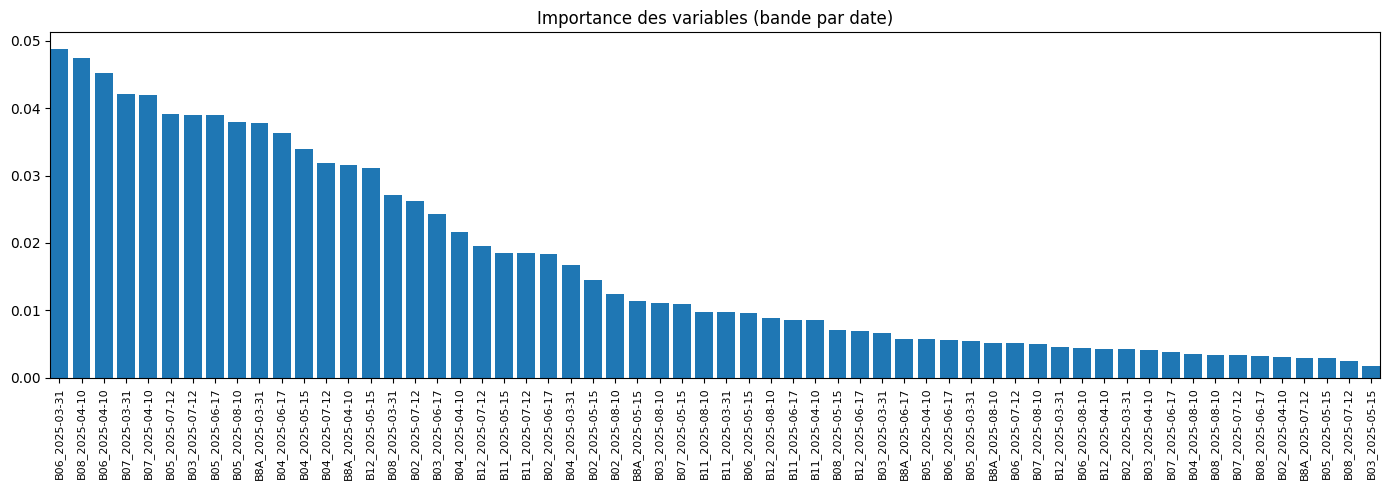

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Importances du Random Forest
importances = best_model.feature_importances_

# Création des labels (Bande - Date)
labels = []
for d in dates:
    for b in bands:
        labels.append(f"{b}_{d}")

# Tri décroissant des importances
idx_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idx_sorted]
labels_sorted = [labels[i] for i in idx_sorted]

# Histogramme
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(importances_sorted)), importances_sorted)
plt.title("Importance des variables (bande par date)")

plt.xticks(
    np.arange(len(labels_sorted)),
    labels_sorted,
    rotation=90,
    fontsize=8
)

# Suppression des marges vides
plt.margins(x=0)

plt.tight_layout()
plt.show()


L'histogramme ci-dessus est **exhaustif** : il affiche les contributions de l'ensemble des 60 variables ``BXX_Date``. Ci-dessous les 10 variables les plus importantes :

In [22]:
df_importance = pd.DataFrame({
    "Variable": labels,
    "Importance": importances
})

df_importance_tri = df_importance.sort_values(
    by="Importance",
    ascending=False
).reset_index(drop=True)

# Affichage des 10 variables les plus importantes
df_importance_tri.head(10)

,Variable,Importance
0,B06_2025-03-31,0.048794
1,B08_2025-04-10,0.047448
2,B06_2025-04-10,0.045142
3,B07_2025-03-31,0.042066
4,B07_2025-04-10,0.041874
5,B05_2025-07-12,0.039073
6,B03_2025-07-12,0.038982
7,B05_2025-06-17,0.038905
8,B05_2025-08-10,0.037997
9,B8A_2025-03-31,0.037764


Mais ces informations ne nous permettent pas de dégager une **tendance** (bandes et dates se « mélangent »). Affichons donc les contributions de chaque bande et de chaque date, diagrammes qui seront plus parlants.

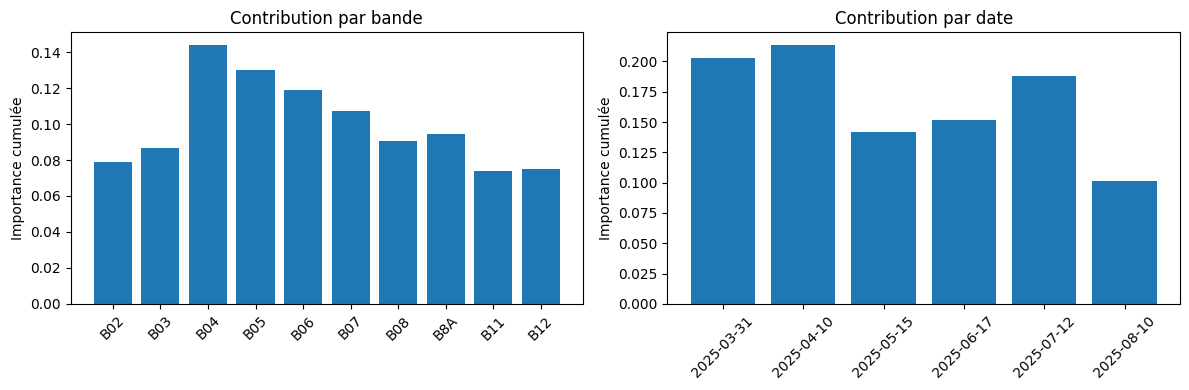

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="bands",
    ax=axes[0]
)

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="dates",
    ax=axes[1]
)

plt.tight_layout()
plt.show()


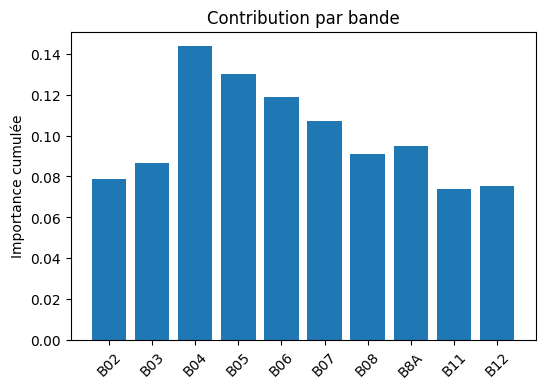

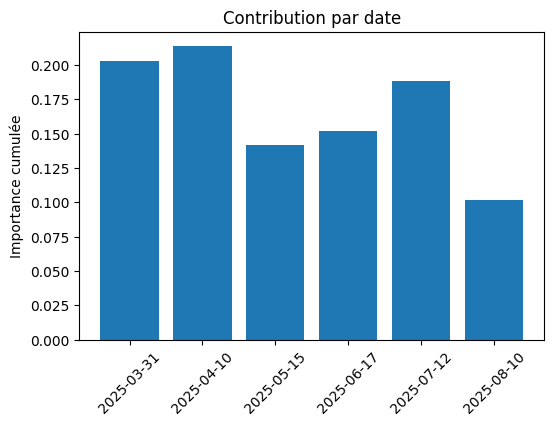

In [26]:
from my_function import plot_contrib

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="bands"
)

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="dates"
)

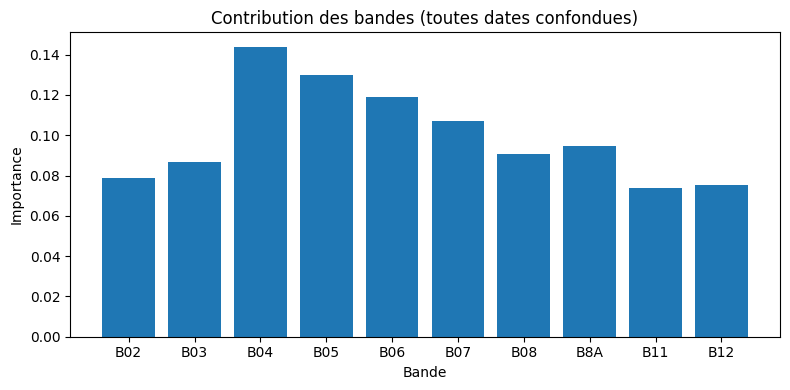

In [24]:
# Remise en forme : (n_dates, n_bands)
imp_mat = importances.reshape(len(dates), len(bands))

# Contribution totale par bande (somme sur toutes les dates)
imp_by_band = imp_mat.sum(axis=0)

# Histogramme des contributions par bande
plt.figure(figsize=(8, 4))
plt.bar(bands, imp_by_band)
plt.title("Contribution des bandes (toutes dates confondues)")
plt.ylabel("Importance")
plt.xlabel("Bande")
plt.tight_layout()
plt.show()

vérifier si B3 et B5 suffisaient ?

## 4.3.4. Production des cartes finales

## 4.3.5. Analyse des résultats

On **sépare les données d'entraînement et de test** pour ne pas qu'un pixel entraîné soit également dans le test (ce qui biaiserait les résultats) :

In [25]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=0)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

### Matrice de confusion

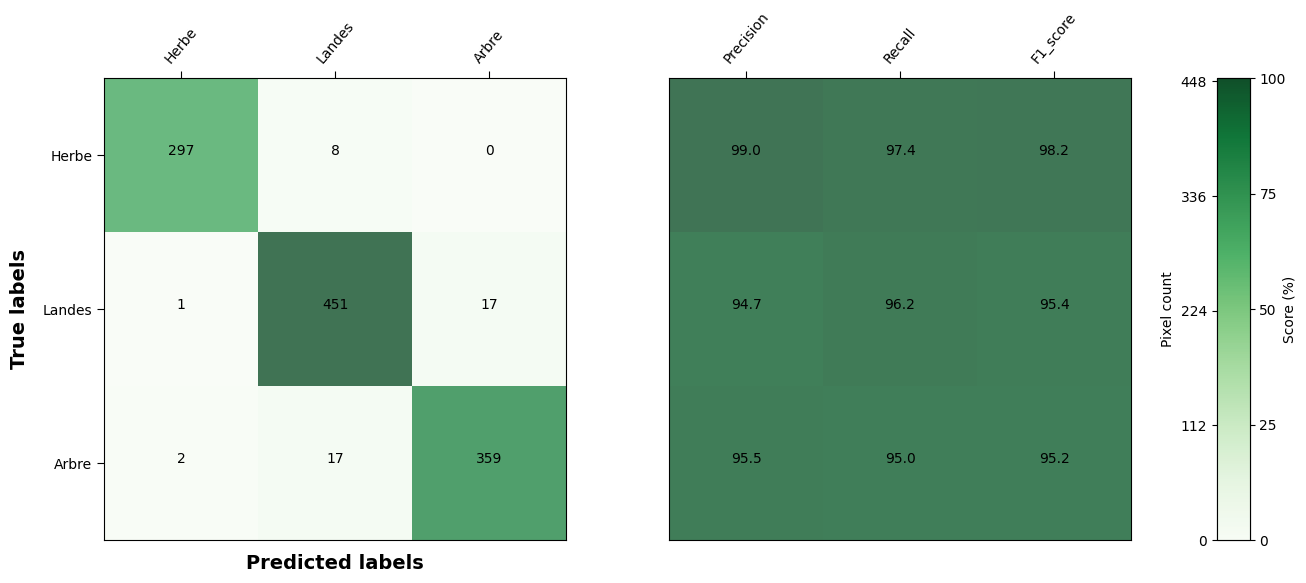

In [26]:
labels_order = np.sort(np.unique(y_test))
labels_text = [labels_strates[int(l)] for l in labels_order]

cm = confusion_matrix(y_test, y_pred, labels=labels_order)

plot_cm(cm,labels_text)
plt.show()


# Discussion

Pour rappel, la classe « sol nu » est absente des données d'entraînement et et ne pourra pas être appris et donc prédite par le modèle. Cela revient à dire que si aucun pixel d'échantillon n'est du sol nu, alors aucun pixel de l'image ne sera classé comme tel. Cependant, les échantillons représentent 0.04 % de l'ensemble des pixels $\left(\frac{3\,839}{938\,196} \right)$ et on peut raisonnablement penser que dans les 99,96 autres % de l'image, il se peut qu'on trouve du sol nu qui ne sera pas prédit par le modèle, quel qu'il soit.